#**Deep Convolutional LSGAN**

In [1]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

In [2]:
workers = 2
batch_size = 64
image_size = 64

nc = 1    # number of channel
nz = 100  # dimension of latent vector z
ngf = 64  # number of features of generator
ndf = 64  # number of features of discriminator

epochs = 50
lr = 0.0002
beta1 = 0.5
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


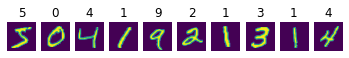

In [4]:
fig = plt.figure()

for i in range(10):
  train_x = dataset.data[i]
  train_y = dataset.targets[i]

  ax = fig.add_subplot(1, 10, i+1)
  ax.imshow(train_x)
  ax.set_title(str(train_y.item()))
  ax.axis("off")

plt.show()

## Generator

[nz, 1, 1] → [4ngf, 4, 4] → [2ngf, 7, 7] → [ngf, 14, 14] → [1, 28, 28]

In [5]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, 4*ngf, 4, 1, 0, bias=False),
        nn.BatchNorm2d(4*ngf),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(4*ngf, 2*ngf, 3, 2, 1, bias=False),
        nn.BatchNorm2d(2*ngf),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(2*ngf, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    return self.main(x)

## Discriminator
[1, 28, 28] → [ndf, 14, 14] → [2ndf, 7, 7] → [4ndf, 4, 4] → [1]

In [6]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(ndf, 2*ndf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(2*ndf),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(2*ndf, 4*ndf, 3, 2, 1, bias=False),
        nn.BatchNorm2d(4*ndf),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(4*ndf, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.main(x)

## Making models & Weight initialization

In [21]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

## (Option) Load from drive


In [ ]:
import pickle
img_list_path = "/content/drive/MyDrive/Colab Notebooks/AirForce/model/LSGAN_v1_img_list.txt"
with open(img_list_path, 'rb') as f:
  img_list = pickle.load(f)

G_save_name = 'LSGAN_v1_G.pt'
D_save_name = 'LSGAN_v1_D.pt'
G_path = F"/content/drive/MyDrive/Colab Notebooks/AirForce/model/{G_save_name}"
D_path = F"/content/drive/MyDrive/Colab Notebooks/AirForce/model/{D_save_name}"

netG.load_state_dict(torch.load(G_path))
netD.load_state_dict(torch.load(D_path))

<All keys matched successfully>

## Loss Functions and Optimizers


In [22]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr*0.2, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

## Training

In [23]:
img_list, G_losses, D_losses = [], [], []
iters = 0

for ep in range(epochs):
  for batch_idx, (image, lbl) in enumerate(dataloader, 0):
    # 1. Update Discriminator
    # 1-1. Train with Real Batch
    netD.zero_grad()
    b_size = image.shape[0]
    image = Variable(image).cuda()
    label = torch.full((b_size,), real_label, device=device)
    label = label.type(torch.cuda.FloatTensor)

    output = netD(image).view(-1)
    errD_real = 0.5 * torch.mean((output-label)**2)
    errD_real.backward()
    D_x = output.mean().item()

    # 1-2. Train with Fake Batch
    noise = torch.randn(b_size,nz, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_label)

    output = netD(fake.detach()).view(-1)
    errD_fake = 0.5 * torch.mean((output-label)**2)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    optimizerD.step() 
    
    # 2. Update Generator
    netG.zero_grad()
    label.fill_(real_label)

    output = netD(fake).view(-1)
    errG = 0.5 * torch.mean((output - label)**2)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

    if batch_idx % 50 == 49:
      print('[%3d/%3d][%3d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
            % (ep+1, epochs, batch_idx+1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      G_losses.append(errG.item())
      D_losses.append(errD.item())
      if (iters % 100 == 0) or ((ep == epochs-1) and (batch_idx == len(dataloader)-1)): 
        with torch.no_grad():
          fake = netG(fixed_noise).detach().cpu()
        img_list.append(fake)
      iters += 1

[  1/100][ 50/938]	Loss_D: 0.1356	Loss_G: 0.2933	D(x): 0.7666	D(G(z)): 0.3971 / 0.2445
[  1/100][100/938]	Loss_D: 0.1370	Loss_G: 0.3003	D(x): 0.6527	D(G(z)): 0.3483 / 0.2289
[  1/100][150/938]	Loss_D: 0.0897	Loss_G: 0.3350	D(x): 0.7264	D(G(z)): 0.2605 / 0.1857
[  1/100][200/938]	Loss_D: 0.1240	Loss_G: 0.2695	D(x): 0.7135	D(G(z)): 0.3529 / 0.2756
[  1/100][250/938]	Loss_D: 0.1573	Loss_G: 0.2183	D(x): 0.5982	D(G(z)): 0.3439 / 0.3472
[  1/100][300/938]	Loss_D: 0.1532	Loss_G: 0.2093	D(x): 0.6137	D(G(z)): 0.3621 / 0.3607
[  1/100][350/938]	Loss_D: 0.1278	Loss_G: 0.2326	D(x): 0.6664	D(G(z)): 0.3525 / 0.3234
[  1/100][400/938]	Loss_D: 0.1387	Loss_G: 0.2651	D(x): 0.6711	D(G(z)): 0.3830 / 0.2763
[  1/100][450/938]	Loss_D: 0.1197	Loss_G: 0.2258	D(x): 0.6712	D(G(z)): 0.3346 / 0.3332
[  1/100][500/938]	Loss_D: 0.1180	Loss_G: 0.2300	D(x): 0.6667	D(G(z)): 0.3303 / 0.3273
[  1/100][550/938]	Loss_D: 0.1059	Loss_G: 0.2089	D(x): 0.6346	D(G(z)): 0.2491 / 0.3585
[  1/100][600/938]	Loss_D: 0.1071	Loss_G: 0

### Check last fake images

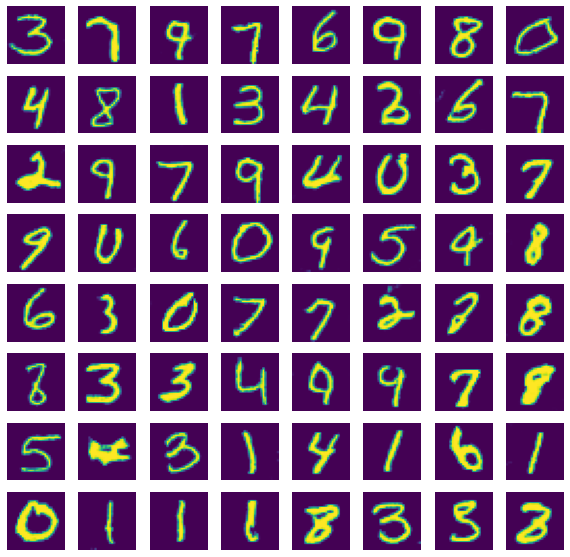

In [24]:
fig = plt.figure(figsize=(10,10))

imgs = img_list[-1].tolist()
for i in range(8):
  for j in range(8):
    img = imgs[8*i+j][0]
    ax = fig.add_subplot(8, 8, 8*i+j+1)
    ax.imshow(img)
    ax.axis("off")

plt.show()

### Plot losses of generator and discriminator

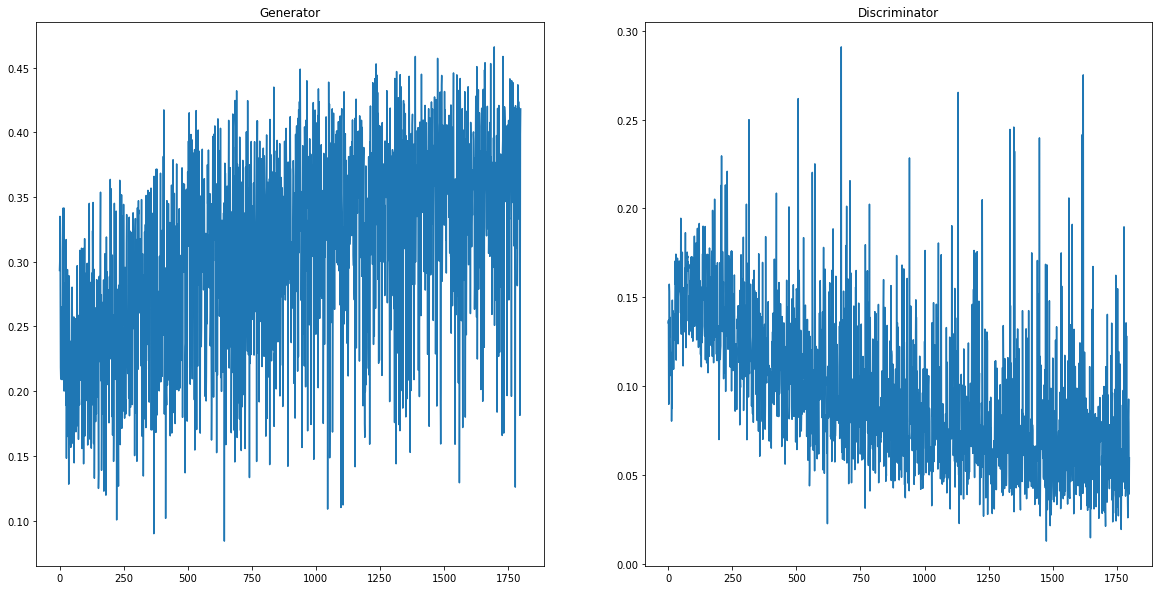

In [25]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 2, 1)
ax.plot(range(len(G_losses)), G_losses)
ax.set_title("Generator")
ax = fig.add_subplot(1, 2, 2)
ax.plot(range(len(D_losses)), D_losses)
ax.set_title("Discriminator")

plt.show()

### Plot how generator improved

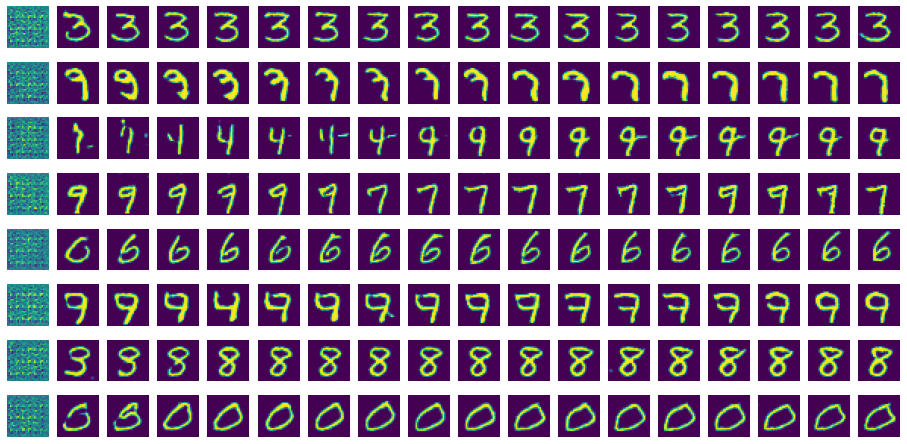

In [26]:
n_img_set = len(img_list)
n_show = 8
SIZE = 16

fig = plt.figure(figsize=(SIZE, SIZE*n_show/16.0))

for k in range(n_img_set):
  imgs = img_list[k].tolist()
  for j in range(n_show):
    img = imgs[j][0]
    ax = fig.add_subplot(n_show, n_img_set, k+j*n_img_set+1)
    ax.imshow(img)
    ax.axis("off")

plt.show()

## Save models and images in drive

In [28]:
G_save_name = 'LSGAN_v1_G.pt'
D_save_name = 'LSGAN_v1_D.pt'
G_path = F"/content/drive/MyDrive/Colab Notebooks/AirForce/model/{G_save_name}"
D_path = F"/content/drive/MyDrive/Colab Notebooks/AirForce/model/{D_save_name}"

torch.save(netG.state_dict(), G_path)
torch.save(netD.state_dict(), D_path)

In [29]:
import pickle
img_list_path = "/content/drive/MyDrive/Colab Notebooks/AirForce/model/LSGAN_v1_img_list.txt"
with open(img_list_path, 'wb') as f:
  pickle.dump(img_list, f)

## Animation

In [30]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

ims = []
SIZE = 10
fig = plt.figure(figsize=(SIZE, SIZE))

imgs = img_list[0].tolist()
for j in range(64):
  ax = fig.add_subplot(8, 8, j+1)
  im = ax.imshow(imgs[j][0])
  ax.axis("off")
  ims.append(im)

def init():
  for j in range(64):
    ims[j].set_data(([[]*8]*8))

  return tuple(ims)

def update(frame):
  imgs = img_list[frame].tolist()
  
  for j in range(64):
    img = imgs[j][0]
    ims[j].set_array(img)

  return tuple(ims)

ani = FuncAnimation(fig=fig, init_func=init, func=update, interval=500, blit=True, frames=range(n_img_set))

plt.show()
clear_output(wait = True)

HTML(ani.to_jshtml())